In [8]:
import os
from actipy import read_device
import matplotlib.pyplot as plt
from config import project_config as config
import pandas as pd

In [9]:
# from config import project_config as config

# psg_markers_path = 'data/PSG markers/'
# for id in config['subject_ids']:
#     df = pd.read_csv(f'{psg_markers_path}/Markers_{id:03d}.txt', skiprows=3, header=None)
#     df = df.rename(columns={0: 'time', 1: 'event'})
#     df['event'] = df['event'].transform(lambda s: s.split(';')[1].strip())
#     lights_fltr = df['event'].str.lower().str.find('lights') >= 0
#     display(df[lights_fltr])

In [10]:
# aws_labels_path = 'data/AWS-Labels'
# aws_df = pd.read_csv(f'{aws_labels_path}/mesa-sleep-{id:04d}_Date_time.csv')

# aws_df['Date_time'] = pd.to_datetime(aws_df['Date_time'])
# day_change_fltr = aws_df['Date_time'].dt.date.diff() > np.timedelta64(1, 's')
# plt.plot(aws_df.index, aws_df['White Light'])
# plt.vlines(x=aws_df[day_change_fltr].index, ymin=0, ymax=25000, color='red', linestyle='dashed')
# plt.ylim((0, 10000))
# plt.savefig('lights.png', dpi=300)

In [11]:
from config import project_config as config
from utils.sleep_wake_filter import filter_sleep_series
import pandas as pd
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    cohen_kappa_score
    )

if __name__ == '__main__':

    merged_sources_path = 'Results/merged_sources/'
    label = 'AWS Sleep'
    models = ['pred', 'Biobank Sleep']
    results = pd.DataFrame()
    all_preds = pd.DataFrame()
    for id in config['subject_ids']:

        df = pd.read_csv(f'{merged_sources_path}/sub_{id:02d}.csv')
        df = df.dropna(subset=[label] + models)  # Drop epochs without a label or prediction
        
        # # # #
        df['pred'] = (df['pred_score'] >= 0.5).astype(int)
        # # # #

        df['pred'] = filter_sleep_series(df['pred'])
        all_preds = pd.concat([all_preds, df])

        metrics = {
            'F-1': f1_score,
            'Recall': recall_score,
            'Precision': precision_score,
            "Cohen's Kappa": lambda y_true, y_pred: cohen_kappa_score(y1=y_true, y2=y_pred),
            'Specificity': lambda y_true, y_pred: classification_report(y_true=y_true, y_pred=y_pred, output_dict=True, labels=[0, 1])['0']['precision']
        }
        
        for model in models:
            metric_values = {metric: [] for metric in metrics.keys()}  # Placeholder for metric values
            for metric, metric_fn in metrics.items():
                temp_df = df.dropna(subset=[model])  # Drop epochs for which this model doesn't have an output
                metric_value = metric_fn(y_pred=temp_df[model], y_true=temp_df[label])
                metric_values[metric].append(round(metric_value * 100, 2))

            metrics_df = pd.DataFrame(metric_values)
            metrics_df.insert(0, 'Subject ID', id)
            metrics_df.insert(1, 'Model', model)
            
            results = pd.concat([results, metrics_df])

    results.to_csv('Metrics.csv', index=False)


In [12]:
from sklearn.metrics import classification_report
from pprint import pprint

print('-' * 80)
print('Us')
rep = classification_report(y_true=all_preds[label], y_pred=all_preds['pred'], output_dict=True)
display(pd.DataFrame(rep).transpose())

print('-' * 80)
print('Biobank')
rep = classification_report(y_true=all_preds[label], y_pred=all_preds['Biobank Sleep'], output_dict=True)
display(pd.DataFrame(rep).transpose())

--------------------------------------------------------------------------------
Us


,precision,recall,f1-score,support
0.0,0.829305,0.694357,0.755855,6.112270e+05
1.0,0.660129,0.805966,0.725794,4.502100e+05
accuracy,0.741696,0.741696,0.741696,7.416964e-01
macro avg,0.744717,0.750162,0.740825,1.061437e+06
weighted avg,0.757549,0.741696,0.743105,1.061437e+06


--------------------------------------------------------------------------------
Biobank


,precision,recall,f1-score,support
0.0,0.846528,0.910528,0.877362,6.112270e+05
1.0,0.864634,0.775887,0.817860,4.502100e+05
accuracy,0.853419,0.853419,0.853419,8.534195e-01
macro avg,0.855581,0.843207,0.847611,1.061437e+06
weighted avg,0.854208,0.853419,0.852124,1.061437e+06


/var/folders/5m/znlstgm107v6b4cw5_hs0dgc0000gp/T/ipykernel_15997/2218218967.py:8: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*rc*pr/(rc+pr)


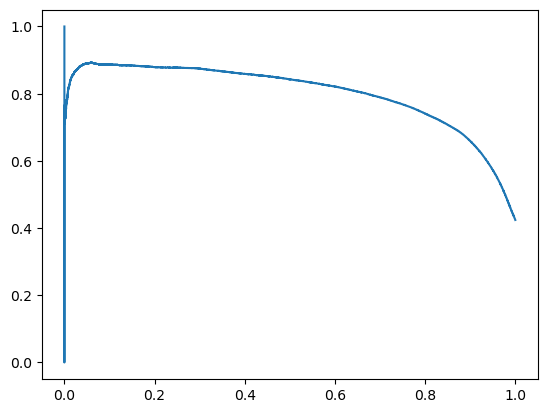

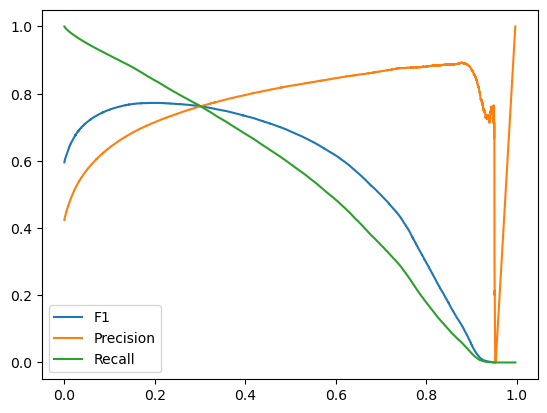

In [14]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# PrecisionRecallDisplay.from_predictions(y_pred=all_preds['pred_score'], y_true=all_preds[label])
pr, rc, th = precision_recall_curve(probas_pred=all_preds['pred_score'], y_true=all_preds[label])
plt.plot(rc, pr)
f1_scores = 2*rc*pr/(rc+pr)
plt.figure()
plt.plot(th, f1_scores[1:], label='F1')
plt.plot(th, pr[1:], label='Precision')
plt.plot(th, rc[1:],  label='Recall')
plt.legend()
